In [1]:
# namespace and import declaration
import m2aia as m2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as rnd
import statistics as stat
import scipy.stats as SST
import scipy.signal as SSI
import skimage.measure as skim
import pandas as pd
import warnings
# hide the warnings, nice for FutureWarnings
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf
#from reportlab.lib.pagesizes import letter
#from reportlab.pdfgen import canvas


In [2]:
# INTERACTIVE FIELD
# load the filename
file_name = r"C:\Users\Jannik\Documents\Uni\Master_Biochem\4_Semester\mzWonderland\data\output.imzML"


# INTERACTIVE FIELD
# load the calibrants
cal_filepath = "D:\\programs\\M2aia\\calibrants_9AA.csv"

# INTERACTIVE FIELD
pdf_generate = False


In [ ]:
## export seam for jupyter ----------------------------------------------------------
if pdf_generate:
    # Create a PDF file to save the figures
    pdf_file_path = file_name[:-6] + "_output_QC(1_4).pdf"
    pdf_pages = matplotlib.backends.backend_pdf.PdfPages(pdf_file_path)
# execute the parsing 
I = m2.ImzMLReader(file_name)
# I.Load() is implicit in the instancing

In [ ]:
I.GetMetaData()

In [4]:
I.GetMetaData()

{'(original imzML value) [IMS:1000042] max count of pixels x': '856',
 '(original imzML value) [IMS:1000043] max count of pixels y': '253',
 '(original imzML value) max count of pixels z': '1',
 '[IMS:1000031] processed': 'true',
 '[IMS:1000042] max count of pixels x': '16',
 '[IMS:1000043] max count of pixels y': '2',
 '[IMS:1000044] max dimension x': '42800',
 '[IMS:1000045] max dimension y': '12650',
 '[IMS:1000046] pixel size x': '0.05',
 '[IMS:1000047] pixel size y': '0.05',
 '[IMS:1000053] absolute position offset x': '0',
 '[IMS:1000054] absolute position offset y': '0',
 '[IMS:1000080] universally unique identifier': '{DCD356A2-A4FF-42B3-A7F6-D613BAFF4A14}',
 '[IMS:1000091] ibd SHA-1': '472E74B354BE80D5709BBF44F19289159FF13287',
 '[IMS:1000101] intensityArray.external data': 'true',
 '[IMS:1000101] mzArray.external data': 'true',
 '[IMS:1000401] scanSettings1.top down': 'true',
 '[IMS:1000410] scanSettings1.meandering': 'true',
 '[IMS:1000480] scanSettings1.horizontal line scan

In [4]:
file_format= I.GetSpectrumType()

if "Profile" in file_format:
    flag_profile = True
    flag_centroid = False
elif "Centroid" in file_format:
    flag_profile = False
    flag_centroid = True
else:
    raise ValueError("The loaded file has an undefined spectrum type.")
    
if "Processed" in file_format:
    flag_processed = True
    flag_continuous = False
elif "Continuous" in file_format:
    flag_processed = False
    flag_continuous = True
else:
    raise ValueError("The loaded file has an undefined alignment type.")
        

In [5]:
# general calulations

# generate a 2D binary mask from the file
pix_pos = np.argwhere(I.GetMaskArray()[0]) # argwher inverts the dimensions, [0] sueezed out 3rd dimension

# get the corners of data entry, is useful to set limits of plotting
x_min, x_max = pix_pos[np.argmin(pix_pos[:,1])][1], pix_pos[np.argmax(pix_pos[:,1])][1]
y_min, y_max = pix_pos[np.argmin(pix_pos[:,0])][0], pix_pos[np.argmax(pix_pos[:,0])][0]

# some calculations use a coverage to not overcalculate 
# for this, set the samplesize here between 0 and 100, high coverage is only useable for small datasets
samplesize_perc = 1 # in %

batch_size = int(I.GetNumberOfSpectra()*(samplesize_perc/100))
randomlist = rnd.sample(range(0, I.GetNumberOfSpectra()), batch_size)


In [5]:
# Visualisation calculations

# Connectec objects Analysis, especially useful for TMAs and other physical conglomerates
labeled_image, label_nr = skim.label(I.GetMaskArray()[0], return_num=True, connectivity=1)

# custom colormaps with white backgrounds (via out-of-lower-bound)
my_vir = cm.get_cmap('viridis').copy()
my_vir.set_under('white')  # Color for values less than vmin
my_rbw = cm.get_cmap('gist_rainbow').copy()
my_rbw.set_under('white')  # Color for values less than vmin


my_coolwarm = cm.get_cmap('coolwarm').copy()
my_coolwarm.set_under('white')  # Color for values less than vmin
my_coolwarm.set_over('darkorange')


my_cw = cm.get_cmap('coolwarm').copy()
my_cw.set_under('purple')  # Color for values less than vmin
my_cw.set_over('darkorange')
my_cw.set_bad(color= 'white', alpha = 1.0)

# make a mask approach to plot any feature based on mapping onto existing image array with a translation apporach
# it transfers pixels from 0 ()in binary image input ) to NaN, which allows them to be set to bad
def mask_bad_image(key_list, # an iterable of valid pixel indices,
               val_list, # an iterable of projected Intensities, matched to key_list
               image # An array-like object with the given distribution of key variables
               ):
    # set up a translational dictionary
    trans_dict = dict(zip(key_list, val_list))
    # Important zero-index conversion, otherwise rounding gives error
    trans_dict[0] = np.nan
    
    # defines the callable function (juhu, we love functional programming
    translate = np.vectorize(
        # defines the callable function (juhu, we love more functional programming
        lambda ele: trans_dict.get(ele,ele))
    return translate(image)


# make a mask approach to plot any feature based on mapping onto existing image array with a translation apporach
# older version, not yet switched in all features to mask_bad_image
def mask_image(key_list, # an iterable of valid pixel indices,
               val_list, # an iterable of projected Intensities, matched to key_list
               image # An array-like object with the given distribution of key variables
               ):
    # set up a translational dictionary
    trans_dict = dict(zip(key_list, val_list))
    # Important zero-index conversion, otherwise rounding gives error
    trans_dict[0] = 0.0
    
    # defines the callable function (juhu, we love functional programming
    translate = np.vectorize(
        # defines the callable function (juhu, we love more functional programming
        lambda ele: trans_dict.get(ele,ele))
    return translate(image)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [8]:
# OUTPUT FIELD
if not pdf_generate:
    # Retrieve metadata and file properties
    print("FILE PROPERTIES \n")
    print("Spectral Type: ", I.GetSpectrumType())
    #TODO use metadata parser by M2aia

In [11]:
# OUTPUT FIELD
if not pdf_generate:
    # Retrieve Image-related data
    print('IMAGE PROPERTIES \n')
    print('Numeric shape of Image (x, y, z): ', I.GetShape())
    print('Number of recorded Pixels: ', I.GetNumberOfSpectra())
    print("Number of unrecorded Pixels: ", np.abs(np.product(I.GetShape()) - I.GetNumberOfSpectra()))

    print("Recorded x-range: ", x_min, " - ", x_max)
    print("Recorded y-range: ", y_min, " - ", y_max)

    print("Nr of connected objects found: ", label_nr)


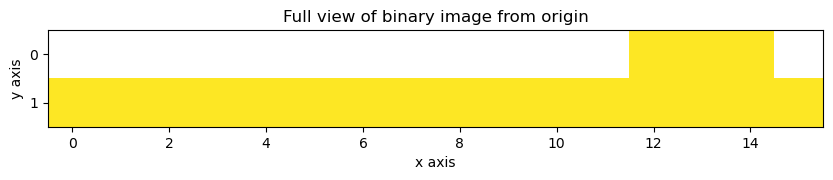

In [6]:
# OUTPUT FIELD
# Image with origin    
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_title('Full view of binary image from origin')
ax.imshow(I.GetMaskArray()[0],
          cmap=my_vir, vmin=0.1,
          interpolation='none') # attention, large images tend to get a smoohing under the hood by plt

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [13]:
# OUTPUT FIELD
# Image of binary mask within image bounds
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title('Cropped view of binary image within pixel limits')
ax.imshow(I.GetMaskArray()[0], 
          cmap=my_vir, vmin=0.1,
         interpolation='none')

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [14]:
# OUTPUT FIELD 
# Pixel index range

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Pixel Index')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(I.GetIndexArray()[0], cmap=my_rbw, vmin=0.1,interpolation='none')
fig.colorbar(im, extend='min')

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [15]:
# OUTPUT FIELD 
# different connected components

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Connected Objects Analysis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(labeled_image, cmap=my_rbw, vmin=0.1,interpolation='none')
fig.colorbar(im, extend='min', format=lambda x, _: f"{int(x)}")

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [16]:
 
# calculation of properties within each pixel, expensive calculation
# Pixelwise calculations operation, loops over .SpectrumIterator

# TODO change tuples to arrays
index_nr = tuple() # container for pixel index, corrected for 0-index
peak_nr = tuple() # container for number of features loaded in a single pixel
tic_nr = tuple() # container of TIC for each single pixel
median_nr = tuple() # Container for the median intnsity in each pixel
max_int_nr = tuple() # Container for the min intnsity in each pixel
min_int_nr = tuple() # Container for the max intnsity in each pixel
max_abun_nr = tuple() # Container for the most abundant mz in each pixel


for ind, mass, inten in I.SpectrumIterator(): # loop to run over full imzML dataset
    # values for a single pixel are recorded in their specific tuples

    index_nr = index_nr + (ind+1,) # pixel order is 0 for not-recorded pixels
    peak_nr = peak_nr + (len(inten),)
    tic_nr = tic_nr + (sum(inten),)
    median_nr += (stat.median(inten),)
    max_int_nr += (max(inten),)
    min_int_nr += (min(inten),)
    max_abun_nr += (mass[np.where(inten==max(inten))[0][0]] ,)
    



In [17]:
# OUTPUT FIELD
if not pdf_generate:
    # gives Information on the spectral properties
    print('SPECTAL PROPERTIES \n ')

    print('Number of individual mz features: ', np.sum(peak_nr))
    print('')
    print("Mean TIC ± sd: ", int(stat.mean(tic_nr)), " ± ", int(stat.stdev(tic_nr)))
    print("Median TIC ± MAD: ", int(stat.median(tic_nr)), " ± ", int(SST.median_abs_deviation(tic_nr)))
    print('')
    print("Mean number of mz features per spectrum ± sd: ", int(stat.mean(peak_nr)), " ± ", int(stat.stdev(peak_nr)))
    print("Median number of mz features per spectrum ± MAD: ",
          int(stat.median(peak_nr)), " ± ", int(SST.median_abs_deviation(peak_nr)))
    print('')
    print("Range of median intensities per pixel: ", min(median_nr), " - ", max(median_nr))
    print('Range of Maximal Intensity per pixel: ', min(max_int_nr), " - ", max(max_int_nr))
    print('Range of minimal Intensity per pixel: ', min(min_int_nr), " - ", max(min_int_nr))
    print('Range of most abundant mz per pixel: ', min(max_abun_nr), " - ", max(max_abun_nr))


In [18]:
# OUTPUT FIELD
# plots of the number of peaks in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Number of Peaks per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('Number of Peaks')


ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr,peak_nr,color='k',marker=".", zorder=-1)
ax.set_rasterization_zorder(0)
#ax.axhline(len(I.GetXAxis()), color='r') # this shows the auto-averaged number of peaks


if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()
    
# PEak number projection
peak_nr_image = mask_image(index_nr,peak_nr,I.GetIndexArray()[0])

# plot
fig = plt.figure(figsize=[7,5])
axs = plt.subplot(111)
axs.set_title(f'Number of Peak Projection')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_xlim(x_min, x_max)
axs.set_ylim(y_min, y_max)
im = axs.imshow(peak_nr_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, ax=axs, extend='min')


if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [19]:
# OUTPUT FIELD
# plots of the TIC in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('TIC per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('Intensity')

ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr,tic_nr,color='b',marker=".",zorder=-1)
ax.set_rasterization_zorder(0)

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()
    
    
# TIC projection:
tic_image = mask_image(index_nr,tic_nr,I.GetIndexArray()[0])
#plot
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.set_title(f'TIC Projection')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(tic_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, extend='min')

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [20]:
# OUTPUT FIELD
# plots of the median intensity in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Median Intensity per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('Intensity')


ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr, median_nr,color='k',marker=".",zorder=-1)
ax.set_rasterization_zorder(0)

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()
    
# projection:
tic_image = mask_image(index_nr,median_nr,I.GetIndexArray()[0])
#plot
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.set_title(f'Median Intensity per Spectrum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(tic_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, extend='min')
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [21]:
# OUTPUT FIELD
# plots of the maximal intensity in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Maximum Intensity per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('Intensity')


ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr, max_int_nr, color='r',marker=".",zorder=-1)
ax.set_rasterization_zorder(0)
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

    
# projection:
max_image = mask_image(index_nr,max_int_nr,I.GetIndexArray()[0])
# plot
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.set_title(f'Maximum Intesnsity per Spectrum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(max_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, extend='min')
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [22]:
# OUTPUT FIELD
# plots of the minimal intensity in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Minimum Intensity per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('Intensity')


ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr, min_int_nr, color='g',marker=".",zorder=-1)
ax.set_rasterization_zorder(0)

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()
    
    
# projection:
min_image = mask_image(index_nr,min_int_nr,I.GetIndexArray()[0])
# plot
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.set_title(f'Minimum Intensity per Spectrum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(min_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, extend='min')
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [23]:
# OUTPUT FIELD
# plots of the minimal intensity in each pixel

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Most abundant mz feature per spectrum')
ax.set_xlabel('Index of Spectrum')
ax.set_ylabel('mz')

ax.grid(visible=True, c='lightgray', ls="--")
ax.scatter(index_nr, max_abun_nr, color='k',marker=".",zorder=-1)
ax.set_rasterization_zorder(0)

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()
    
    
# projection
mab_image = mask_image(index_nr,max_abun_nr,I.GetIndexArray()[0])

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.set_title(f'Most abundant mz feature per Spectrum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
im = ax.imshow(mab_image, cmap=my_vir, vmin=0.1)
fig.colorbar(im, extend='min')
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [24]:

#linear reshaping of pixel index image and segmented image
ind_ar = np.reshape(I.GetIndexArray()[0],-1)
lab_ar = np.reshape(labeled_image, -1)

# arrayization of pixel index counting and TICperPixel counting
ind_nr_ar = np.asarray(index_nr) 
tic_nr_ar = np.asarray(tic_nr) 

#collectors for plotable boxplot data
tic_coll_boxplot = []
name_coll_boxplot = []

# loop over all segments
for seg in range(1,label_nr+1):
    pindex = ind_ar[np.where(lab_ar==seg)]+1 # extracion of pixel indices per segment 
    tics = tic_nr_ar[np.in1d(ind_nr_ar,pindex)] # extraction of tics from pixel index
    tics = np.log10(tics)

    tic_coll_boxplot.append(tics)
    name_coll_boxplot.append(seg)

    

In [25]:
# OUTPUT IMAGE
# Boxplot of  TIC intensity distribution in each segment
len_b40 = len(name_coll_boxplot) // 40
if (len(name_coll_boxplot) % 40) > 0:
    len_b40 = len_b40 + 1

# plotting functions based on single-line or multi-line plotting:
if len_b40 > 1:    
    fig, ax = plt.subplots(len_b40, figsize=(10,len_b40*3))
    fig.suptitle('Boxplots of Pixelwise TIC per Segment')
    
    for j in range(1,len_b40+1): # change to 1-base index
        ax[j-1].boxplot(tic_coll_boxplot[(j-1)*40:40*j],
                       labels=name_coll_boxplot[(j-1)*40:40*j])
        ax[j-1].set_xlabel('Segmented Group')
        ax[j-1].set_ylabel('log10 of Pixel TIC')

else:
    fig = plt.figure(figsize=[10,len_b40*3])
    ax = plt.subplot(111)
    ax.set_title('Boxplots of Pixelwise TIC per Segment')
    
    ax.boxplot(tic_coll_boxplot,
               labels=name_coll_boxplot)
    ax.set_xlabel('Segmented Group')
    ax.set_ylabel('log10 of Pixel TIC')
     
plt.tight_layout()
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [26]:
len(randomlist)

14

In [27]:
if flag_processed:

    first_mz, _ = I.GetSpectrum(0)
    len_first_mz = len(first_mz)
    processed_collector = first_mz

    for id in randomlist:
        mz, _ = I.GetSpectrum(id)
        # assumes that the instrument makes same amount of data points in each pixel
        if len_first_mz == len(mz):
            processed_collector = np.hstack((processed_collector,mz))
        else:
            print(id)
            #raise ValueError(f" Pixel {id} has a non-identical number of data points that reference.")

    print(np.shape(processed_collector))
    processed_collector = processed_collector.T
    dpoint_mean = tuple() # collector for mean mz value of each pseudo-bin
    dpoint_spread = tuple() # collector of the standard variation within each pseudo-bin
    
    print(np.shape(processed_collector))
    for row in processed_collector:
        print(row)
        dpoint_mean += (stat.mean(row),)
        dpoint_spread += (stat.stdev(row),)

    dpoint_mean = np.asarray(dpoint_mean)
    dpoint_spread = np.asarray(dpoint_spread)
    dbin_spread = np.diff(dpoint_mean) # calculation of inter-bin step size 

    fig = plt.figure(figsize=[7,5])
    ax = plt.subplot(111)

    ax.set_title('Comparison of aquisition-based binning')
    ax.set_xlabel('mz of each pseudo-bin')
    ax.set_ylabel('mz deviation')

    ax.grid(visible=True, c='lightgray', ls="--")

    ax.plot(dpoint_mean, dpoint_spread, color='r',zorder=-1, 
            label=f"standard deviation \nwithin each pseudo-bin \nmedian: {stat.median(dpoint_spread):.6f}")

    ax.plot(dpoint_mean[:-1], dbin_spread, color='g',zorder=-1, 
            label=f"Stepsize between \neach pseudo-bin \nmedian: {stat.median(dbin_spread):.6f}")
    ax.legend()

    ax.set_rasterization_zorder(0)
    if pdf_generate:
        pdf_pages.savefig(fig)
        plt.close()
    else:
        plt.show()


14
578
1205
984
123
755
1325
181
385
1260
258
1281
73
388
(143,)
(143,)
78.97616


TypeError: 'numpy.float32' object is not iterable

In [32]:
# Parametrisation for Accuracy and Bining
cal = pd.read_csv(cal_filepath, sep=';', header=0)
cal_masses = cal["Theoretical m/z"].tolist()
cal_names = cal["Name"].tolist()
# instancing the collection list: 
# list for each calibrant containing an array per calibrant[i] with mass[i][0] and intensity[i][1]
accu_cal = []
accu_list = []
for i in range(len(cal_masses)):
    accu_list.append(np.array([[],[]]))
        
# peak binning with overbinning to 0.00005 resolution (very accurate)
dist = 0.025
bins = int(2*dist/(5*10**-5))
#TODO what tf is this? where do these parameters come from? are they necesarry?

In [33]:
# and looping over calibrants
for i, calmass in enumerate(cal_masses):
    # looping over sample
    for ind in randomlist:
        mass, intensity = I.GetSpectrum(ind)
        # implement empty pixel flags
        try:
            #mindex needs to be inclusive
            mindex = min(np.where(mass > (calmass-dist))[0])
            mindex_flag = True
        except:
            mindex_flag = False
        try: 
            #maxdex needs to be exclusive 
            maxdex = min(np.where(mass > (calmass+dist))[0])
            maxdex_flag = True
        except:
            maxdex_flag = False

        if maxdex_flag and mindex_flag:
            # collecting of masses and intensities
            adder = np.array((mass[mindex:maxdex],intensity[mindex:maxdex]))
            accu_list[i] = np.concatenate((accu_list[i], adder), axis=1)
    


In [34]:
# OUTPUT IMAGE
# mass accuracy plots

nrowfig = len(cal_masses)//3
if (len(cal_masses)%3) != 0:
    nrowfig += 1
    
# on plotting calculation of most abundant mz feature
# collection in accu_mab_list

#collectors for mabs and valid entries
accu_mab_list = []
cal_mass_mask= []
accu_center_list = []

# extraction of most Abundant PEaks and theeir validity in mask for cal_masses
for i in range(len(cal_masses)):
    if len(accu_list[i][1]) > 0:
        most_abundant_peak = accu_list[i][0][np.where(accu_list[i][1]==max(accu_list[i][1]))][0]    
        accu_mab_list.append(most_abundant_peak)
        cal_mass_mask.append(True)
        center, _ = accu_list[i].mean(axis=1)
        
        accu_center_list.append(center)
    else:
        accu_mab_list.append(0) # mab is set to 0 for not found peaks to retain list shape
        cal_mass_mask.append(False)
        accu_center_list.append(0) # center is set to 0 for not found peaks




for i in range(len(cal_masses)):   
    fig = plt.figure(figsize=[7,5])
    ax = plt.subplot(111)
    ax.set_title(f'Spectrum of {cal_masses[i]} ({cal_names[i]})')
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    ax.set_xlim(cal_masses[i]-0.025, cal_masses[i]+0.025)
    ax.ticklabel_format(useOffset=False,)
    ax.ticklabel_format(axis="y",style='sci',scilimits=(0,0))
    ax.scatter(accu_list[i][0], accu_list[i][1],s=4, zorder=-1)
    ax.set_rasterization_zorder(0)
    # check if peak is valid
    if cal_mass_mask[i]:
        most_abundant_peak = accu_mab_list[i]
        ax.axvline(most_abundant_peak, color='green', ls="--")
        ax.axvline(cal_masses[i], c='r', ls=(0,(1,3)))
        
        # get data for 
        ax.axvline(accu_center_list[i], c='purple', ls="-.")

        
    else:
         ax.text(cal_masses[i], 0,'Peak \n not found', 
                ha='center', fontsize=12)


    if pdf_generate:
        pdf_pages.savefig(fig)
        plt.close()
    else:
        plt.show()


In [35]:
# calculate difference of most abundant peak to theoretical mass in ppm
ppm_mds = []
for o,t,m in zip(accu_mab_list,cal_masses,cal_mass_mask):
    if m:
        ppm_mds.append(np.abs((o-t)/t*10**6))

labels = []
accu_masses = []
for t,l,m  in zip(cal_masses,cal_names,cal_mass_mask):
    if m:
        labels.append(l)
        accu_masses.append(t)
# make names
#from names list take len
y_pos = np.arange(len(labels))


def addlabels(x,y):
    for i in range(len(x)):
        ax.text(i, y[i]+0.5, np.round(y[i],5), 
                ha='center', fontsize=8)

fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Absolute mass accuracy of calibrants (most abundant mass vs theoretical)')
ax.set_xlabel('Calibrant')
ax.set_ylabel('Mass accuracy in ppm')
ax.set_xticks(y_pos)
ax.set_xticklabels(labels, rotation=45, fontsize=8)

ax.bar(y_pos, ppm_mds, color="green")

# making the bar chart on the data
addlabels(y_pos, ppm_mds)
     

if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [36]:
# calculate difference of most abundant peak to theoretical mass in ppm
ppm_cen = []
for o,t,m in zip(accu_center_list,cal_masses,cal_mass_mask):
    if m:
        ppm_cen.append(np.abs((o-t)/t*10**6))
        
labels = []
accu_masses = []
for t,l,m  in zip(cal_masses,cal["Name"].tolist(),cal_mass_mask):
    if m:
        labels.append(l)
        accu_masses.append(t)
# make names
#from names list take len
y_pos = np.arange(len(labels))


fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)

ax.set_title('Absolute mass accuracy of calibrants (centered peak vs theoretical)')
ax.set_xlabel('Calibrant')
ax.set_ylabel('Mass accuracy in ppm')
ax.set_xticks(y_pos)
ax.set_xticklabels(labels, rotation=45, fontsize=8)

ax.bar(y_pos, ppm_cen,  color="purple")

# making the bar chart on the data
addlabels(y_pos, ppm_cen)
     
if pdf_generate:
    pdf_pages.savefig(fig)
    plt.close()
else:
    plt.show()

In [37]:
# for heapmap of mass accuracy per spectra: 


# loop over each pixel to get ind, mass, inten
# loop over valid masses to get theoretical mass
# find nearest mz feature around theoretical mass
# collect it per pixel in df: rows (dim 0): pixel index, cols: valid masses, fields: nearest
# then calculate ppm values per column
# and make heatmap with accuracy

# f: rows (dim 0): pixel index, cols: valid masses, fields: nearest
accuracies_ar = np.zeros((I.GetNumberOfSpectra(),len(accu_masses)))
for ind, mass, inten in I.SpectrumIterator(): # loop to run over full imzML dataset
    # get nearest elements TODO: change to nearest local maxima
    tm = [find_nearest(mass, calmass) for calmass in accu_masses]    
    accuracies_ar[ind] = tm
# transpose to match  ppm calcs form
accuracies_ar = accuracies_ar.T



In [38]:
for i, mass in enumerate(accu_masses):
    accu_ppm_ar = [(o-mass)/mass*10**6 for o in accuracies_ar[i]]
    
    
    a_image = mask_bad_image(index_nr,accu_ppm_ar,I.GetIndexArray()[0])
    # plot

    
    fig = plt.figure(figsize=[7,5])
    ax = plt.subplot(111)
    ax.set_title(f'Mass Accuracy of {mass}, {labels[i]}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    im = ax.imshow(a_image, cmap=my_cw, vmin=-20, vmax=20)
    fig.colorbar(im, extend='both',label="ppm")
    
    if pdf_generate:
        pdf_pages.savefig(fig)
        plt.close()
    else:
        plt.show()

In [39]:
# range of binned mz values
mz_min = min(I.GetXAxis())
mz_max = max(I.GetXAxis())

# binned intensity range
int_min = min(I.GetMeanSpectrum())
int_max = max(I.GetMeanSpectrum())

if not pdf_generate:
    print('AVERAGE SPECTRUM PROPERTIES \n ')

    print('mz range:', mz_min.round(5), " - ", mz_max.round(5))
    print("Spacing:", I.GetSpacing())
    print("m/z Bins:", I.GetXAxisDepth())
    print('Intensity range: ',int_min.round(0), " - ", int_max.round(0))



In [40]:
if flag_centroid:
    # plot the autobinned mean spectra
    fig = plt.figure(figsize=[10,6])
    ax = plt.subplot(111)
    ax.set_title('Averaged Centroid Mass Spectrum')
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    ax.set_xlim(mz_min.round(0),mz_max.round(0))
    ax.vlines(I.GetXAxis(), 0, I.GetMeanSpectrum(),linewidth = 0.8)
    
    if pdf_generate:
        pdf_pages.savefig(fig)
        plt.close()
    else:
        plt.show()
        
if flag_profile:
    # plot the autobinned mean spectra
    fig = plt.figure(figsize=[10,6])
    ax = plt.subplot(111)
    ax.set_title('Averaged Profile Mass Spectrum')
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    ax.set_xlim(mz_min.round(0),mz_max.round(0))
    ax.plot(I.GetXAxis(), I.GetMeanSpectrum(),linewidth = 0.8)
    
    if pdf_generate:
        pdf_pages.savefig(fig)
        plt.close()
    else:
        plt.show()

0.0074691772

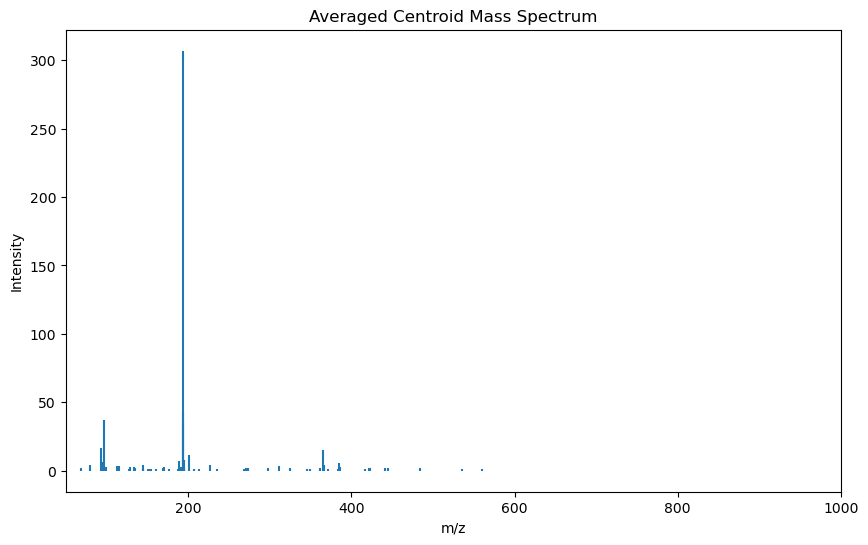

In [41]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(111)
ax.set_title('Averaged Centroid Mass Spectrum')
ax.set_xlabel('m/z')
ax.set_ylabel('Intensity')
ax.set_xlim(mz_min.round(0),mz_max.round(0))
ax.vlines(I.GetSpectrum(200)[0], 0, I.GetSpectrum(200)[1])
a = I.GetSpectrum(200)[0]
min(np.diff(a))

In [42]:
# OUTPUT FIELD
# Retrieve metadata and file properties
print("\n FILE PROPERTIES \n")
print("Spectral Type: ", I.GetSpectrumType())
#print(I.GetMetaData())
#TODO use metadata parser by M2aia

# Retrieve Image-related data
print('\n IMAGE PROPERTIES \n')
print('Numeric shape of Image (x, y, z): ', I.GetShape())
print('Number of recorded Pixels: ', I.GetNumberOfSpectra())
print("Number of unrecorded Pixels: ", np.abs(np.product(I.GetShape()) - I.GetNumberOfSpectra()))

print("Recorded x-range: ", x_min, " - ", x_max)
print("Recorded y-range: ", y_min, " - ", y_max)

print("Nr of connected components found: ", label_nr)

# OUTPUT FIELD
# gives Information on the spectral properties
print('\n SPECTAL PROPERTIES \n ')

print('Number of individual mz features: ', np.sum(peak_nr))
print('')
print("Mean TIC ± sd: ", int(stat.mean(tic_nr)), " ± ", int(stat.stdev(tic_nr)))
print("Median TIC ± MAD: ", int(stat.median(tic_nr)), " ± ", int(SST.median_abs_deviation(tic_nr)))
print('')
print("Mean number of mz features per spectrum ± sd: ", int(stat.mean(peak_nr)), " ± ", int(stat.stdev(peak_nr)))
print("Median number of mz features per spectrum ± MAD: ",
      int(stat.median(peak_nr)), " ± ", int(SST.median_abs_deviation(peak_nr)))
print('')
print("Range of median intensities per pixel: ", min(median_nr), " - ", max(median_nr))
print('Range of Maximal Intensity per pixel: ', min(max_int_nr), " - ", max(max_int_nr))
print('Range of Maximal Intensity per pixel: ', min(min_int_nr), " - ", max(min_int_nr))
print('Range of most abundant mz per pixel: ', min(max_abun_nr), " - ", max(max_abun_nr))

    
print('\n AVERAGE SPECTRUM PROPERTIES \n ')
print('mz range:', mz_min.round(5), " - ", mz_max.round(5))
print("Spacing:", I.GetSpacing())
print("m/z Bins:", I.GetXAxisDepth())
print('Intensity range: ',int_min.round(0), " - ", int_max.round(0))
print(f"Calibrant found: {cal_mass_mask.count(True)} / {len(cal_mass_mask)}")


 FILE PROPERTIES 

Spectral Type:  ProcessedCentroid

 IMAGE PROPERTIES 

Numeric shape of Image (x, y, z):  [892 280   1]
Number of recorded Pixels:  1418
Number of unrecorded Pixels:  248342
Recorded x-range:  820  -  891
Recorded y-range:  250  -  279
Nr of connected components found:  1

 SPECTAL PROPERTIES 
 
Number of individual mz features:  211726

Mean TIC ± sd:  811  ±  316
Median TIC ± MAD:  719  ±  68

Mean number of mz features per spectrum ± sd:  149  ±  163
Median number of mz features per spectrum ± MAD:  103  ±  25

Range of median intensities per pixel:  1.243100881576538  -  2.7631612
Range of Maximal Intensity per pixel:  220.25586  -  317.1497
Range of Maximal Intensity per pixel:  1.0000008  -  1.1017429
Range of most abundant mz per pixel:  96.97338  -  193.07864

 AVERAGE SPECTRUM PROPERTIES 
 
mz range: 50.24128  -  999.69994
Spacing: [0.05 0.05 0.01]
m/z Bins: 2000
Intensity range:  1.0  -  131.0
Calibrant found: 6 / 9


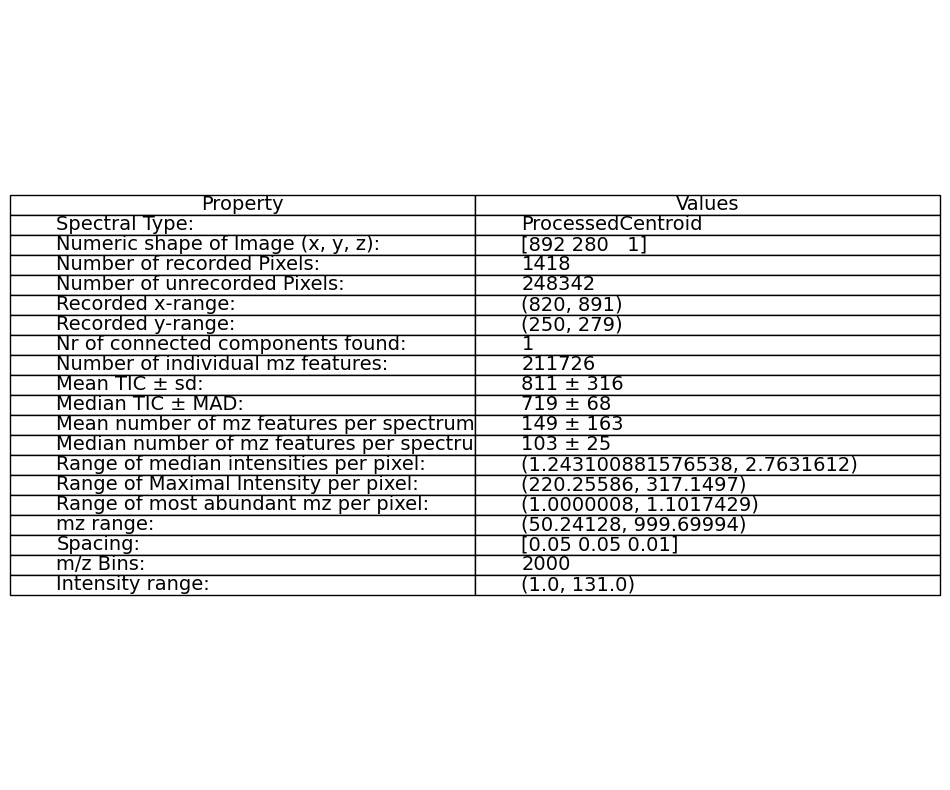

In [43]:
# Define the text data as a list of lists for the table

table_data = [
    ["Spectral Type:", str(I.GetSpectrumType())],
    ["Numeric shape of Image (x, y, z):", str(I.GetShape())],
    ["Number of recorded Pixels:", str(I.GetNumberOfSpectra())],
    ["Number of unrecorded Pixels:", str(np.abs(np.product(I.GetShape()) - I.GetNumberOfSpectra()))],
    ["Recorded x-range:", str((x_min, x_max))],
    ["Recorded y-range:", str((y_min, y_max))],
    ["Nr of connected components found:", str(label_nr)],
    ["Number of individual mz features:", str(np.sum(peak_nr))],
    ["Mean TIC ± sd:", str(f"{int(stat.mean(tic_nr))} ± {int(stat.stdev(tic_nr))}")],
    ["Median TIC ± MAD:", str(f"{int(stat.median(tic_nr))} ± {int(SST.median_abs_deviation(tic_nr))}")],
    ["Mean number of mz features per spectrum ± sd:", str(f"{int(stat.mean(peak_nr))} ± {int(stat.stdev(peak_nr))}")],
    ["Median number of mz features per spectrum ± MAD:", str(f"{int(stat.median(peak_nr))} ± {int(SST.median_abs_deviation(peak_nr))}")],
    ["Range of median intensities per pixel:", str((min(median_nr), max(median_nr)))],
    ["Range of Maximal Intensity per pixel:", str((min(max_int_nr), max(max_int_nr)))],
    ["Range of most abundant mz per pixel:", str((min(min_int_nr), max(min_int_nr)))],
    ["mz range:", str((mz_min.round(5), mz_max.round(5)))],
    ["Spacing:", str(I.GetSpacing())],
    ["m/z Bins:", str(I.GetXAxisDepth())],
    ["Intensity range:", str((int_min.round(0), int_max.round(0)))],
]


# Create a figure and add the table
fig, ax = plt.subplots(figsize=(10, 10))  # Letter size in inches
ax.axis("off")  # Turn off axis
table = ax.table(cellText=table_data,
                 colLabels=["Property", "Values"],
                 loc="center", cellLoc="left")

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Adjust table scale for better layout
 # weird error, where some text is not getting passed
    

In [44]:

if pdf_generate:
    pdf_pages.savefig(fig, bbox_inches="tight")
    plt.close()
    pdf_pages.close()
    
## export seam for jupyter ----------------------------------------------------------